# DRAFT

In [213]:
import pystan
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import linspace,hstack
import seaborn as sns; sns.set_context('notebook')

In [214]:
%matplotlib inline

In [215]:
# Import data
fish_productivity = pd.read_csv('./fish_catch_LME_npp_cb_per_km2.txt', sep="\t")

In [216]:
fish_productivity.head(4)

,OBJECTID,LME_NUMBER,LME_NAME,SUM_GIS_KM,npp_sum_LME,mean_catch_tonnage_1950_2014,mean_catch_tonnage_10yr_2004_2014,npp_ton_carbon,npp_carbon_ton_per_km2,tenyr_catch_km2
0,60,1,East Bering Sea,1320000.0,2.540000e+17,817460.2,900743.1,254000000.0,192.42,0.682
1,4,2,Gulf of Alaska,1530000.0,3.270000e+17,871076.7,853269.1,327000000.0,213.73,0.558
2,10,3,California Current,2220000.0,4.120000e+17,865133.0,1036357.0,412000000.0,185.59,0.467
3,20,4,Gulf of California,223000.0,4.650000e+16,403243.5,565684.0,46500000.0,208.52,2.540


In [217]:
fish_productivity.describe()

,OBJECTID,LME_NUMBER,SUM_GIS_KM,npp_sum_LME,mean_catch_tonnage_1950_2014,mean_catch_tonnage_10yr_2004_2014,npp_ton_carbon,npp_carbon_ton_per_km2,tenyr_catch_km2
count,64.000000,64.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,64.000000,64.000000
mean,32.531250,32.515625,1.253031e+06,2.201125e+17,1.305330e+06,1.572794e+06,2.201125e+08,181.822031,1.496814
std,18.674292,18.646241,9.367712e+05,1.644576e+17,1.703443e+06,2.360390e+06,1.644576e+08,55.496956,2.004151
min,1.000000,1.000000,1.040000e+05,1.760000e+16,4.600801e+02,3.320988e+02,1.760000e+07,38.250000,0.000305
25%,16.750000,16.750000,6.195000e+05,1.097500e+17,1.433230e+05,1.566965e+05,1.097500e+08,152.557500,0.201500
50%,32.500000,32.500000,1.020000e+06,1.735000e+17,7.644404e+05,6.972654e+05,1.735000e+08,183.270000,0.719500
75%,48.250000,48.250000,1.485000e+06,2.940000e+17,1.891549e+06,1.628511e+06,2.940000e+08,206.622500,1.995000
max,66.000000,65.000000,4.340000e+06,6.990000e+17,9.753014e+06,1.221295e+07,6.990000e+08,330.260000,9.300000


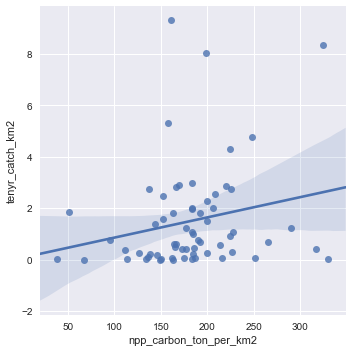

In [218]:
# Here we just want to plot the data over time. 
sns_plot = sns.lmplot("npp_carbon_ton_per_km2", "tenyr_catch_km2", data=fish_productivity, fit_reg=True)
sns_plot.savefig("fish_catch_vs_npp.png")

### Log transform the data

In [219]:
fish_productivity['log_tenyr_catch_km2'] = np.log(fish_productivity['tenyr_catch_km2'])
fish_productivity['log_npp_carbon_ton_per_km2'] = np.log(fish_productivity['npp_carbon_ton_per_km2'])

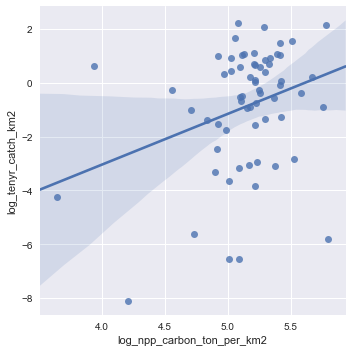

In [220]:
# Here we just want to plot the data over time. 
sns_plot = sns.lmplot("log_npp_carbon_ton_per_km2", "log_tenyr_catch_km2", data=fish_productivity, fit_reg=True)
sns_plot.savefig("log_fish_catch_vs_npp.png")

In [225]:
x = fish_productivity.log_tenyr_catch_km2.tolist()
y = fish_productivity.log_npp_carbon_ton_per_km2.tolist()
N = len(x)
N2 = 64

In [226]:
# make a dictionary containing all data to be passed to STAN
regress_dat = {'x': x,
 'y': y,
 'N': N,
 'N2':N2}

In [243]:
regress_code = """

data {
  int<lower=0> N;
  int N2;
  vector[N] y;
  vector[N] x;
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

model {
  alpha ~ normal(0,10);    
  beta ~ cauchy(0,5);
  sigma ~ cauchy(0,5);
  for (n in 1:N)
    y[n] ~ normal(alpha + beta * x[n], sigma);
}

generated quantities {
  real y_pred;
  
  y_pred = normal_rng(alpha + beta * x[N2], sigma);

} 

"""

In [244]:
# Fit the model
fit = pystan.stan(model_code=regress_code, data=regress_dat, verbose=True,
 iter=2000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5df110baccf5c571a3a244e2922b5921 NOW.
INFO:pystan:OS: darwin, Python: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.25.2


Compiling /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/stanfit4anon_model_5df110baccf5c571a3a244e2922b5921_6581554555821249636.pyx because it changed.
[1/1] Cythonizing /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/stanfit4anon_model_5df110baccf5c571a3a244e2922b5921_6581554555821249636.pyx
building 'stanfit4anon_model_5df110baccf5c571a3a244e2922b5921_6581554555821249636' extension
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var/folders
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var/folders/sz
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T
creating /var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0000gn/T/tmpzcaw1_u5/var/folders/sz/c8lxp6kj6yq89fhnzt2nxqhc0

In [245]:
# model summary
print(fit)

Inference for Stan model: anon_model_5df110baccf5c571a3a244e2922b5921.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    5.19  9.7e-4   0.05   5.09   5.16   5.19   5.22   5.28   2445    1.0
beta     0.05  3.5e-4   0.02   0.01   0.04   0.05   0.06   0.09   3200    1.0
sigma    0.36  6.0e-4   0.03    0.3   0.34   0.36   0.38   0.43   3128    1.0
y_pred   5.24  6.2e-3   0.37   4.52   4.99   5.23   5.49   5.94   3483    1.0
lp__    33.03    0.03   1.27  29.67  32.45  33.34  33.94  34.45   2051    1.0

Samples were drawn using NUTS at Wed Oct 18 10:35:00 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


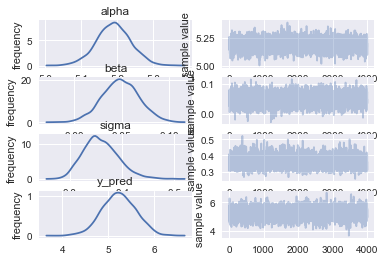

In [246]:
# show a traceplot of ALL parameters. This is a bear if you have many
fit.traceplot()
plt.show()

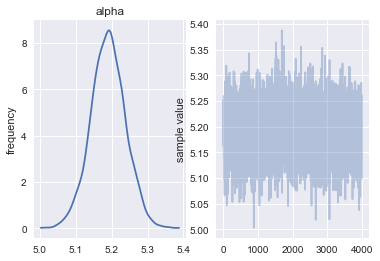

In [247]:
# Instead, show a traceplot for single parameter
fit.plot(['alpha'])
plt.show()

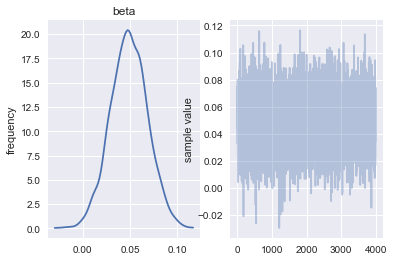

In [248]:
# Instead, show a traceplot for single parameter
fit.plot(['beta'])
plt.show()

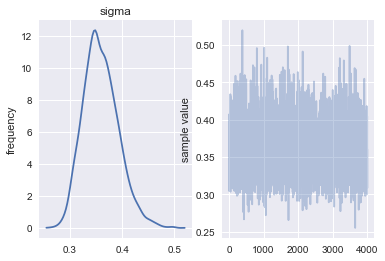

In [249]:
# Instead, show a traceplot for single parameter
fit.plot(['sigma'])
plt.show()

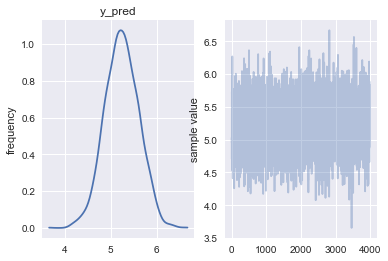

In [250]:
# Instead, show a traceplot for single parameter
fit.plot(['y_pred'])
plt.show()